In [43]:
from langgraph.graph import StateGraph,START,END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from typing import TypedDict,Annotated,Literal
from pydantic import BaseModel, Field
load_dotenv()
model=ChatOpenAI(model="gpt-4o-mini")


In [44]:
#structured output model for sentiment analysis
class StructuredOutput(BaseModel):
    sentiment:Literal["positive","negative"]=Field(description="Sentiment of the reviewed text")

structured_model=model.with_structured_output(StructuredOutput)


#structured output model for diagnosis Schema
class DiagnosisSchema(BaseModel):
    issue_type:Literal["UX","Performance","BUG","Support","other"]=Field(description="Type of issue identified in the review")
    tone:Literal["angry","happy","neutral","sad"]=Field(description="Tone of the review")
    urgency:Literal["high","medium","low"]=Field(description="Urgency level of the issue mentioned in the review")

structured_model_diagnosis=model.with_structured_output(DiagnosisSchema)


In [45]:
#define the state
class SentimentState(TypedDict):
    review_text: str
    sentiment: Literal["positive","negative"]
    diagnosis:dict
    response:str

In [46]:
def find_sentiment(state:SentimentState)->SentimentState:
    prompt=f'provide the sentiment for the given text:{state["review_text"]}'
    output=structured_model.invoke(prompt)
    return {"sentiment":output.sentiment}

def check_sentiment(state:SentimentState)->Literal['positive_response','run_diagnosis']:
    if state['sentiment']=='positive':
        return 'positive_response'
    elif state['sentiment']=='negative':
        return 'run_diagnosis'

def positive_response(state:SentimentState)->SentimentState:
    return {'response':'Thank you for your positive review! We appreciate your feedback.'}

def run_diagnosis(state:SentimentState)->SentimentState:
    prompt=f'Analyze and tell me the Return issue_type , tone and urgency for the :{state["review_text"]}'
    output=structured_model_diagnosis.invoke(prompt)
    return {'diagnosis':output.model_dump()} # to add to the dictionary

def negative_response(state:SentimentState)->SentimentState:
    diagnosis=state['diagnosis']
    prompt=f"""You are a support assistant.
    The user had a '{diagnosis['issue_type']}' issue, sounded {diagnosis['tone']},
    and marked urgency as {diagnosis['urgency']}.
    Write an empathetic, helpful resolution message"""
    output=model.invoke(prompt)
    return {'response':output.content}

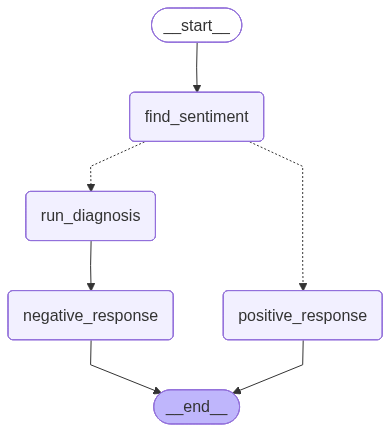

In [47]:
#define the nodes
graph=StateGraph(SentimentState)
graph.add_node('find_sentiment',find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)
               
#add edges
graph.add_edge(START,'find_sentiment')
graph.add_conditional_edges('find_sentiment',check_sentiment)
graph.add_edge('positive_response',END)

graph.add_edge('run_diagnosis','negative_response')
graph.add_edge('negative_response',END)


graph.compile()


In [ ]:
workflow=graph.compile()

#test the workflow
initial_state={'review_text':"""I've been using this app for about a month now, and I must say, the user interface is incredibly clean and intuitive. Everything is exactly where you'd expect it to be. It's rare to find something that just works without needing a tutorial. Great job to the design team!!."""}

final_state=workflow.invoke(initial_state)

print(f"Final State: {final_state}")
